# Exploratory Analysis of the Data


This notebook displays some demonstrates observed features of the collected data.


## Environment Setting


In [1]:
# Import IPython.
from IPython import *
from IPython.display import *


In [2]:
# Import standard library.
import copy
import enum
import functools
import math
import numbers
import random
import six
import sys
import time


In [3]:
# Import SciPy packages.
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
#import sympy as sym
import scipy as sp
import scipy.optimize as spopt
from mpl_toolkits.mplot3d import Axes3D


In [4]:
%matplotlib inline


In [5]:
#sym.init_printing()


In [6]:
plt.style.use('default')


***Python* version and versions of packages**

Output on the original machine:

```
Python version:
	3.8.2 (default, Apr 27 2020, 15:53:34) 
	[GCC 9.3.0]
SciPy version: 1.4.1
NumPy version: 1.18.3
Pandas version: 1.0.3
Matplotlib version: 3.2.1

```


In [7]:
print(
    "Python version:\n\t{v:s}".format(
        v = sys.version.strip().replace("\n", "\n\t")
    )
)
print("SciPy version: {v:s}".format(v = sp.__version__))
print("NumPy version: {v:s}".format(v = np.__version__))
print("Pandas version: {v:s}".format(v = pd.__version__))
print("Matplotlib version: {v:s}".format(v = mpl.__version__))


Python version:
	3.8.2 (default, Apr 27 2020, 15:53:34) 
	[GCC 9.3.0]
SciPy version: 1.4.1
NumPy version: 1.18.3
Pandas version: 1.0.3
Matplotlib version: 3.2.1


## Scores


Read data&hellip;


In [8]:
# Read data from Excel spreadsheet.
df = pd.read_excel(
    'data/eurovision_song_contest_1975_2019v3.xlsx',
    sheet_name = 'Data',
    header = 0,
    names = [
        'year',
        'contest_level',
        'edition',
        'by',
        'from',
        'to',
        'points',
        'duplicate'
    ],
    index_col = None,
    converters = {
        'contest_level': (
            lambda level:
                'semifinal' if level.upper() in {'SF', 'SF1', 'SF2'}
                else 'final' if level.upper() == 'F'
                else None
        ),
        'by': (
            lambda scorer:
                'jury' if scorer.upper() == 'J'
                else 'televoting' if scorer.upper() == 'T'
                else None
        ),
        'duplicate': (
            lambda double:
                True if double.upper() == 'X'
                else False if double is None or double == str()
                else None
        )
    }
)

# Drop unnecessary rows and columns.
df.dropna(axis = 0, how = 'any', inplace = True)
df.drop(
    df.index[df.duplicate | (df.contest_level != 'final')],
    axis = 0,
    inplace = True
)
df.drop(
    ['contest_level', 'edition', 'by', 'from', 'duplicate'],
    axis = 1,
    inplace = True
)

# Aggregate by the accumulated score.
df = df.groupby(
    ['to', 'year'],
    axis = 0,
    sort = False
).sum().reset_index(drop = False, inplace = False, col_fill = None)
df.columns = ['country', 'year', 'score']
df.sort_values(
    ['year', 'country', 'score'],
    axis = 0,
    ascending = [True, True, False],
    inplace = True
)
df.reset_index(drop = True, inplace = True)
df = df.copy(deep = True)


Check the resulting data frame:


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  1032 non-null   object
 1   year     1032 non-null   int64 
 2   score    1032 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 24.3+ KB


In [10]:
df.sample(
    10,
    replace = False
).sort_index(axis = 0, ascending = True, inplace = False)


,country,year,score
91,Switzerland,1979,60
175,Finland,1984,46
524,Slovenia,1999,50
554,Bosnia & Herzegovina,2001,29
576,United Kingdom,2001,28
699,Armenia,2007,138
709,Hungary,2007,128
716,Serbia,2007,268
781,France,2010,82
851,Belarus,2013,48


Extract countries&hellip;


In [11]:
countries = np.array(
    np.sort(np.asarray(pd.unique(df.country))),
    dtype = str,
    copy = True,
    order = 'F'
)


In [12]:
countries


array(['Albania', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Belarus', 'Belgium', 'Bosnia & Herzegovina', 'Bulgaria',
       'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia',
       'F.Y.R. Macedonia', 'Finland', 'France', 'Georgia', 'Germany',
       'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy',
       'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco',
       'Montenegro', 'Morocco', 'North Macedonia', 'Norway', 'Poland',
       'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia',
       'Serbia & Montenegro', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'The Netherlands', 'Turkey', 'Ukraine',
       'United Kingdom', 'Yugoslavia'], dtype='<U20')

Observe some descriptive statistics&hellip;


In [13]:
stats = df.groupby(
    'year',
    axis = 0,
    sort = False
).agg(
    score_sum = pd.NamedAgg('score', lambda x: x.sum(axis = 0)),
    score_mean = pd.NamedAgg('score', lambda x: x.mean(axis = 0)),
    score_std = pd.NamedAgg('score', lambda x: x.std(axis = 0, ddof = 1))
)
stats.sort_values(
    ['score_sum', 'score_mean', 'score_std'],
    axis = 0,
    ascending = [False, False, True],
    inplace = True
)
stats.sort_index(axis = 0, ascending = True, inplace = True)
stats = stats.copy(deep = True)


In [14]:
stats.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 1975 to 2019
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   score_sum   45 non-null     int64  
 1   score_mean  45 non-null     float64
 2   score_std   45 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.4 KB


In [15]:
stats.sample(
    10,
    replace = False
).sort_index(axis = 0, ascending = True, inplace = False)


,score_sum,score_mean,score_std
year,,,
1979,1102,58.000000,36.496575
1983,1160,58.000000,44.972506
1986,1160,58.000000,46.223712
1987,1276,58.000000,44.200840
1991,1276,58.000000,50.106553
1992,1334,58.000000,43.693145
1995,1334,58.000000,42.073529
2001,1334,58.000000,57.036671
2006,2204,91.833333,84.783954


**Nota bene.** Relative and normalised scores are multiplied by $ 100 $.


Compute relative scores (relative to the sum of all scores in the year)&hellip;


In [16]:
rdf = df.copy(deep = True)
rdf['score'] = (
    100.0 * rdf['score'] / np.asarray(stats.loc[rdf.year, 'score_sum'])
)


In [17]:
rdf.sample(
    10,
    replace = False
).sort_index(axis = 0, ascending = True, inplace = False)


,country,year,score
29,Monaco,1976,8.908046
235,Germany,1987,11.050157
246,Switzerland,1987,2.037618
289,Switzerland,1989,3.683386
378,Portugal,1993,4.137931
587,Germany,2002,1.221264
744,Sweden,2008,1.884523
826,Cyprus,2012,2.668309
901,Albania,2015,1.465517
984,Cyprus,2018,8.740978


Compute normalised scores ($ \frac{\left( X - \mu \right)}{\sigma} $, where $ \mu $ is the mean score of the year and $ \sigma $ is the standard deviation of scores in the year)&hellip;


In [18]:
ndf = df.copy(deep = True)
ndf['score'] = (
    100.0 *
    (ndf['score'] - np.asarray(stats.loc[ndf.year, 'score_mean'])) /
    np.asarray(stats.loc[ndf.year, 'score_std'])
)


In [19]:
ndf.sample(
    10,
    replace = False
).sort_index(axis = 0, ascending = True, inplace = False)


,country,year,score
60,Germany,1978,56.549878
89,Spain,1979,158.919021
255,France,1988,14.559848
286,Portugal,1989,-47.603537
352,Norway,1992,-80.104099
597,Sweden,2002,29.920327
698,United Kingdom,2006,-78.827809
758,Greece,2009,27.018758
922,Russia,2015,209.484088
1020,Malta,2019,-51.974911


Observe relative scores of France, Germany and UK through years:


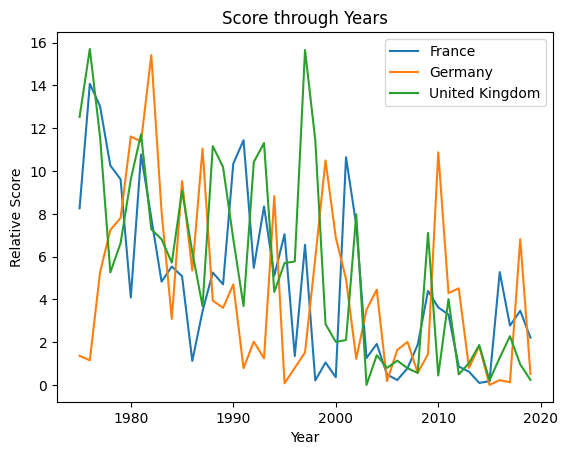

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)

for country in ['France', 'Germany', 'United Kingdom']:
    I = rdf.country == country
    ax.plot(
        rdf.loc[I, 'year'],
        rdf.loc[I, 'score'],
        marker = 'None',
        linestyle = '-',
        label = country
    )

ax.set_title('Score through Years')
ax.set_xlabel('Year')
ax.set_ylabel('Relative Score')

ax.legend(loc = 'upper right')

plt.show()


Observe normalised scores of France, Germany and UK through years:


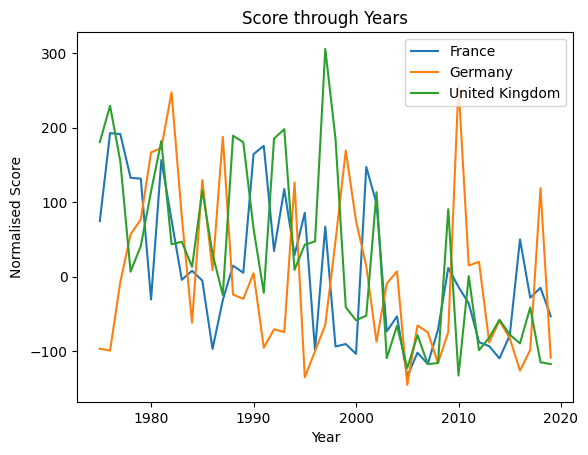

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)

for country in ['France', 'Germany', 'United Kingdom']:
    I = ndf.country == country
    ax.plot(
        ndf.loc[I, 'year'],
        ndf.loc[I, 'score'],
        marker = 'None',
        linestyle = '-',
        label = country
    )

ax.set_title('Score through Years')
ax.set_xlabel('Year')
ax.set_ylabel('Normalised Score')

ax.legend(loc = 'upper right')

plt.show()
